In [1]:
# Parameters definition
# --Lx arg Length of the domain in the x-direction.
# --Ly arg Length of the domain in the y-direction.
# --Nx arg Number of grid points in x-direction.
# --Ny arg Number of grid points in y-direction.
# --dt arg Time step size.
# --T  arg Final time.
# --Re arg Reynolds number.

In [2]:
import numpy as np

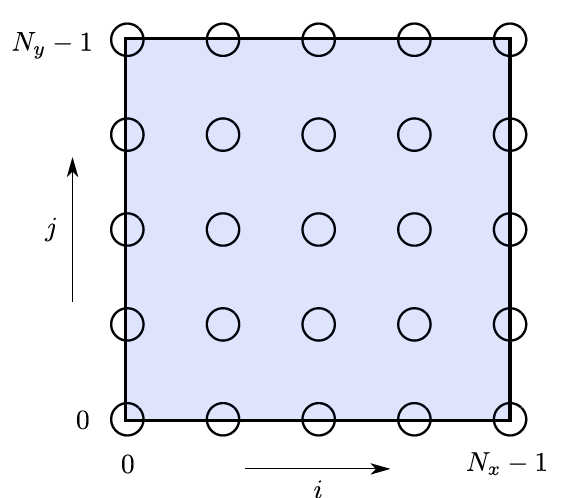

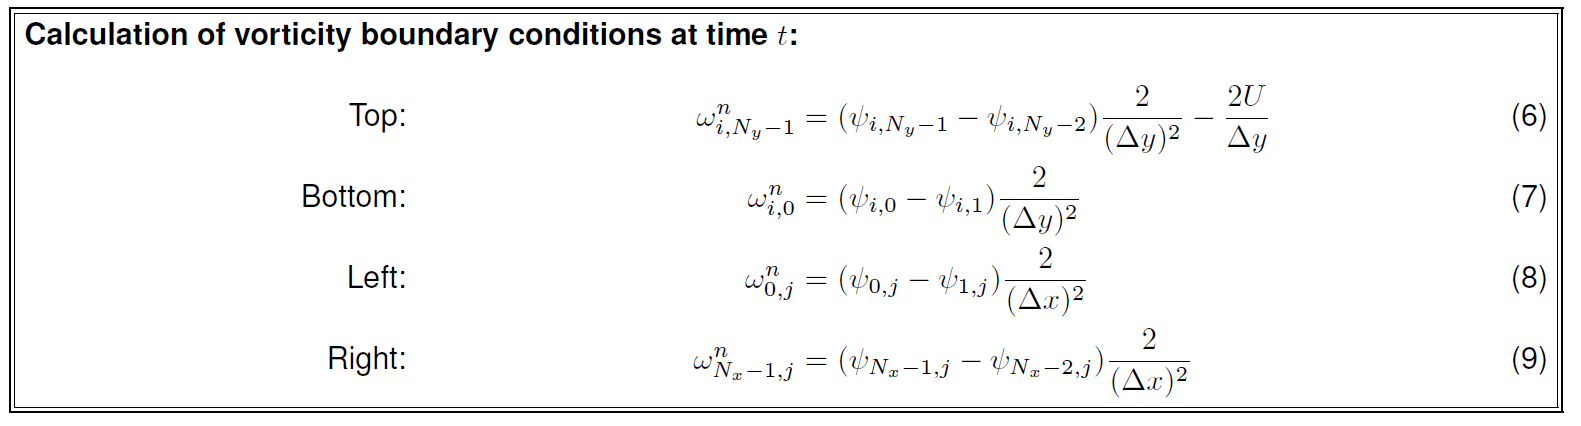

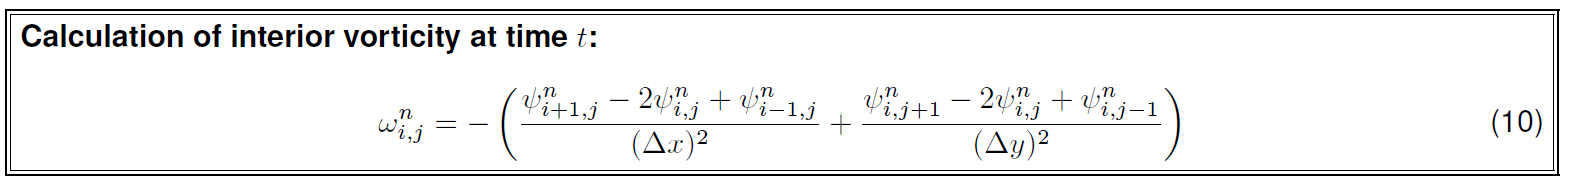

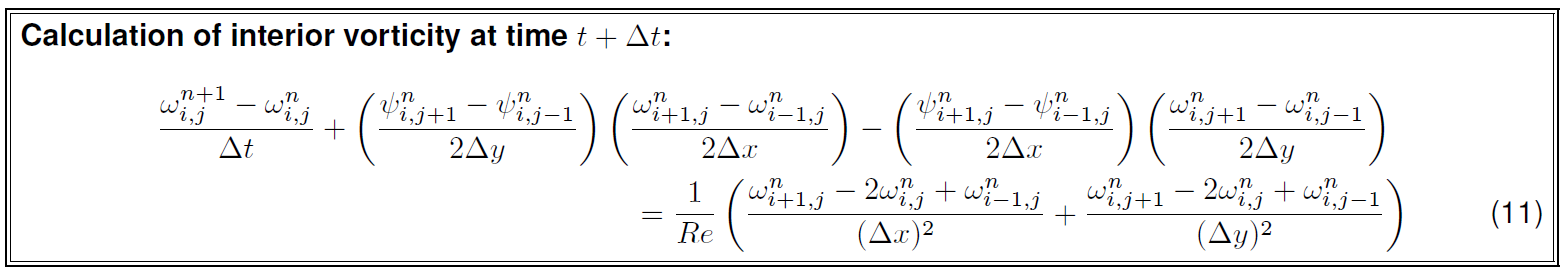

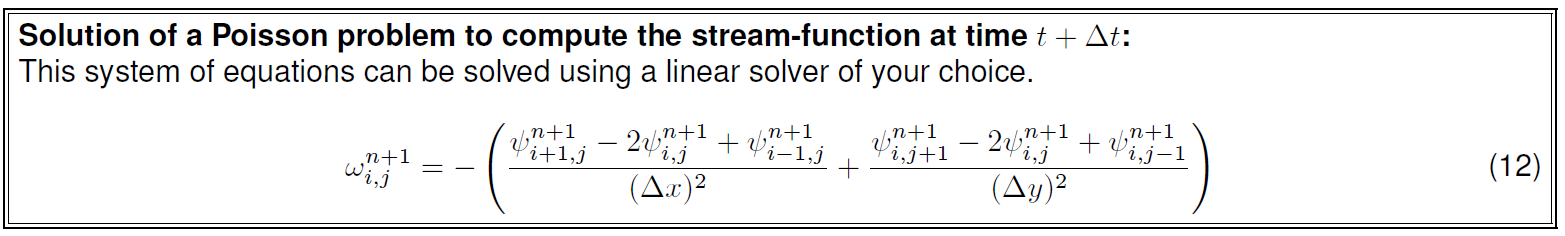

In [3]:
# Insert parameter values
U = 1.0
Lx = 1.0
Ly = 1.0
Nx = 5
Ny = 5
dt = 0.0001
T = 1.0
Re = 100

In [4]:
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
assert dt < Re * dy * dx / 4, f'dt should be larger than {Re * dy * dx / 4}'

In [5]:
phi = np.zeros(shape=(Ny, Nx))
omega = np.zeros(shape=(Ny, Nx))

In [6]:
def update_top(omega, phi, dy, U):
    omega[0, :] = (phi[0, :] - phi[1, :]) * 2 / dy**2 - 2 * U / dy
    return omega


def update_bottom(omega, phi, dy, U):
    omega[-1, :] = (phi[-1, :] - phi[-2, :]) * 2 / dy**2
    return omega


def update_left(omega, phi, dx, U):
    omega[:, 0] = (phi[:, 0] - phi[:, 1]) * 2 / dx**2
    return omega

            
def update_right(omega, phi, dx, U):
    omega[:, -1] = (phi[:, -1] - phi[:, -2]) * 2 / dx**2
    return omega


def update_interior(omega, phi, dx, dy, U):
    for rows in range(1, Ny-1):
        for cols in range(1, Nx-1):
            omega[rows, cols] = (phi[rows, cols+1] - 2*phi[rows, cols] + phi[rows, cols-1]) / dx**2
            omega[rows, cols] = omega[rows, cols] + (
                                phi[rows+1, cols] - 2*phi[rows, cols] + phi[rows-1, cols]) / dy**2
            omega[rows, cols] = -omega[rows, cols]
            
    return omega

def update_vorticity(omega, phi, dx, dy, U):
    omega = update_top(omega, phi, dy, U)
    omega = update_bottom(omega, phi, dy, U)
    omega = update_left(omega, phi, dx, U)
    omega = update_right(omega, phi, dx, U)
    omega = update_interior(omega, phi, dx, dy, U)
    return omega

In [7]:
def next_interior_vorticity(omega, phi, dx, dy, dt, Re):
    for row in range(1, Ny-1):
        for col in range(1, Nx-1):
            rhs = (omega[row, col+1] - 2*omega[row, col] + omega[row, col-1]) / dx**2
            rhs += (omega[row+1, col] - 2*omega[row, col] + omega[row-1, col]) / dy**2
            rhs /= Re
            
            lhs1 = (phi[row+1, col] - phi[row-1, col]) * (omega[row, col+1] - omega[row, col-1])
            lhs1 /= (4 * dx * dy)
    
            lhs2 = (phi[row, col+1] - phi[row, col-1]) * (omega[row+1, col] - omega[row-1, col]) 
            lhs2 /= (4 * dx * dy)
            
            omega[row, col] += dt * (rhs - lhs1 + lhs2)
            
    return omega

In [8]:
def flat_index(row, col, total_rows):
    # for column major only
    return total_rows * col + row

# Interior stream function
def solve_interior_stream(omega, phi, dx, dy):
    Ny, Nx = omega.shape
    n_equations = (Nx-2) * (Ny-2)
    A = np.zeros(shape=(n_equations, n_equations))
    b = np.zeros(shape=(n_equations, ))
    
    for i in range(n_equations):
        current_col = i // (Ny-2) # this denotes the column we are in
        current_row = i % (Ny-2)  # this denotes the row we are in
        
        b[i] = omega[current_row + 1, current_col + 1]
        # index for psi(i, j)
        A[i, flat_index(current_row, current_col, Ny-2)] = 2.0 / dx ** 2 + 2.0 / dy ** 2
        
        if current_col > 0:
            A[i, flat_index(current_row, current_col-1, Ny-2)] = - 1 / dx ** 2
        if current_col < (Nx-3):
            A[i, flat_index(current_row, current_col+1, Ny-2)] = - 1 / dx ** 2
        if current_row > 0:
            A[i, flat_index(current_row-1, current_col, Ny-2)] = - 1 / dy ** 2
        if current_row < (Ny-3):
            A[i, flat_index(current_row+1, current_col, Ny-2)] = - 1 / dy ** 2
    
    x = np.linalg.solve(A, b)
    
    counter = 0
    for col in range(1, Nx-1):
        for row in range(1, Ny-1):
            phi[row, col] = x[counter]
            counter += 1
    
    return phi

In [9]:
time_passed = 0
res_omega = []
res_phi = []

while time_passed <= T:
    
    omega = update_vorticity(omega, phi, dx, dy, U)
    omega = next_interior_vorticity(omega, phi, dx, dy, dt, Re)
    phi = solve_interior_stream(omega, phi, dx, dy)
    time_passed += dt
    
    res_omega.append(omega.copy())
    res_phi.append(phi.copy())

In [10]:
omega

array([[ 0.        , -6.99678694, -7.04970007, -7.44184219,  0.        ],
       [ 1.00321306, -1.30719607, -0.86744135, -0.48930435,  0.55815781],
       [ 0.44840016, -0.06819997, -0.06588255, -0.01875129,  0.30372142],
       [ 0.14898137,  0.01922128,  0.01218245,  0.0164525 ,  0.11419583],
       [ 0.        ,  0.14898137,  0.18596207,  0.11419583,  0.        ]])

In [11]:
phi

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.03135302, -0.02969861, -0.01744298,  0.        ],
       [ 0.        , -0.01401373, -0.01578337, -0.00949177,  0.        ],
       [ 0.        , -0.00465602, -0.0058117 , -0.0035688 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [12]:
import matplotlib.pyplot as plt

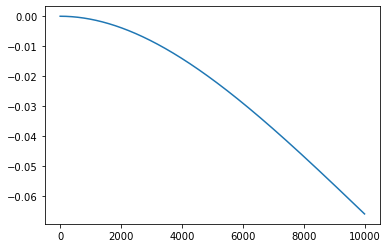

In [13]:
plt.plot([r[2, 2] for r in res_omega])

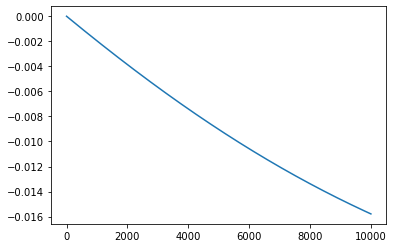

In [14]:
plt.plot([r[2, 2] for r in res_phi])

In [15]:
# def vorticity_top(Nx, Ny, dy, U):
#     A = np.zeros(shape=(Nx, 2 * Nx*Ny))
#     for i in range(Nx):
#         A[i, i * (Ny)] = 1.0  # index for omega (i, Ny -1)
#         A[i, i * (Ny) + Nx * Ny] = -2 / dy ** 2  # index for psi (i, Ny - 1)
#         A[i, i * (Ny) + Nx * Ny + 1] = 2 / dy ** 2  # index for psu (i, Ny - 2)
    
#     b = np.full(shape=(Nx,), fill_value= -2 * U / dy)
#     return A, b

# def vorticity_bottom(Nx, Ny, dy, U):
#     A = np.zeros(shape=(Nx, 2 * Nx*Ny))
#     for i in range(Nx):
#         A[i, (Ny - 1) + i * (Ny)] = 1.0  # index for omega (i, 0)
#         A[i, (Ny - 1) + i * (Ny) + Nx * Ny] = -2 / dy ** 2  # index for psi (i, 0)
#         A[i, (Ny - 1) + i * (Ny) + Nx * Ny - 1] = 2 / dy ** 2  # index for psi (i, 1)
    
#     b = np.full(shape=(Nx,), fill_value=0.0)
#     return A, b

# def vorticity_left(Nx, Ny, dx, U):
#     A = np.zeros(shape=(Ny, 2 * Nx*Ny))
#     for i in range(Ny):
#         A[i, i] = 1.0  # index for omega (0, j)
#         A[i, i + Nx * Ny] = -2 / dx ** 2  # index for psi (0, j)
#         A[i, i + Nx * Ny + Ny] = 2 / dx ** 2  # index for psi (1, j)
    
#     b = np.full(shape=(Nx,), fill_value= 0.0)
#     return A, b 

# def vorticity_right(Nx, Ny, dx, U):
#     A = np.zeros(shape=(Ny, 2 * Nx*Ny))
#     for i in range(Ny):
#         A[i, i + (Nx - 1) * Ny] = 1.0  # index for omega (Nx - 1, j)
#         A[i, i + (Nx - 1) * Ny + Nx * Ny] = -2 / dx ** 2  # index for psi (Nx - 1, j)
#         A[i, i + (Nx - 2) * Ny + Nx * Ny] = 2 / dx ** 2  # index for psi (Nx - 2, j)
    
#     b = np.full(shape=(Nx,), fill_value= 0.0)
#     return A, b

# def flat_index(row, col, total_rows):
#     # for col major only
#     return total_rows * col + row

# def interior_vorticity(Nx, Ny, dx, dy, U):
#     n_equations = (Nx-2)*(Ny-2)
#     A = np.zeros(shape=(n_equations, 2 * Nx*Ny))
#     for i in range(n_equations):
#         current_col = i // (Ny-2) + 1 # this denote column we are in
#         current_row = i % (Ny-2) + 1 # this denote row we are in
        
#         A[i, flat_index(current_row, current_col, Ny)] = 1.0  # index for omega (i, j)
#          # index for psi (i, j)
#         A[i, flat_index(current_row, current_col, Ny) + Nx * Ny] = -2.0 / dx ** 2 - 2.0 / dy ** 2
        
        
#         A[i, flat_index(current_row, current_col+1, Ny) + Nx * Ny] = 1 / dx ** 2  # index for psi (0, j)
#         A[i, flat_index(current_row, current_col-1, Ny) + Nx * Ny] = 1 / dx ** 2  # index for psi (0, j)
        
#         A[i, flat_index(current_row+1, current_col, Ny) + Nx * Ny] = 1 / dy ** 2  # index for psi (0, j)
#         A[i, flat_index(current_row-1, current_col, Ny) + Nx * Ny] = 1 / dy ** 2  # index for psi (0, j)
    
#     b = np.full(shape=(n_equations,), fill_value= 0.0)
#     return A, b

# def boundary_conditions(Nx, Ny, dx, dy, U):
#     n_equations = 2 * Ny + 2 * (Nx - 2) + 4  # 4 for the corners
#     A = np.zeros(shape=(n_equations, 2 * Nx*Ny))
#     counter = 0
#     ##### for psi
#     # left/right boundary
#     for i in range(Ny):
#         A[counter, flat_index(i, 0, Ny) + Nx * Ny] = 1.0
#         A[counter + 1, flat_index(i, Nx-1, Ny) + Nx * Ny] = 1.0
#         counter += 2
    
#     # top/bottom excluding left right boundary
#     for col in range(1, Nx-1):
#         A[counter, flat_index(0, col, Ny) + Nx * Ny] = 1.0
#         A[counter + 1, flat_index(Ny-1, col, Ny) + Nx * Ny] = 1.0
#         counter += 2
    
#     ### for omega, set corners
#     A[counter, flat_index(Ny-1, 0, Ny) + Nx * Ny] = 1.0
#     A[counter+1, flat_index(Ny-1, Nx-1, Ny) + Nx * Ny] = 1.0
#     # top corners
#     A[counter+2, flat_index(0, 0, Ny) + Nx * Ny] = 1.0
#     A[counter+3, flat_index(0, Nx-1, Ny) + Nx * Ny] = 1.0
    
#     # top corners are non-zero b
#     b = np.full(shape=(n_equations,), fill_value= 0.0)
#     b[-2] = -2 * U / dy  # second last equation
#     b[-1] = -2 * U / dy  # last equation
    
#     return A, b

# def conditions_at_t(Nx, Ny, dx, dy, U):
#     At, bt = vorticity_top(Nx, Ny, dy, U)
#     Ab, bb = vorticity_bottom(Nx, Ny, dy, U)
#     Al, bl = vorticity_left(Nx, Ny, dx, U)
#     Ar, br = vorticity_right(Nx, Ny, dx, U)
#     Ai, bi = interior_vorticity(Nx, Ny, dx, dy, U)
#     A_b, b_b = boundary_conditions(Nx, Ny, dx, dy, U)
    
#     return np.row_stack((At, Ab, Al, Ar, Ai, A_b)), np.concatenate((bt, bb, bl, br, bi, b_b))